# Gemma Analytics Hiring Test – Surgeon Skill Ranking

Author: David Gonzalez  
Date: 11.07.2025

This notebook analyzes the performance of surgeons conducting hip replacement operations based on EQ-5D-5L questionnaire results.

In [1]:
from sqlalchemy import create_engine
import pandas as pd

# DB Credentials
db_user = 'c50c162d93e1b19027aafe01f4915371e'
db_pass = 'f1c1e1f88935a9c21b05e200cc938c0c'
db_host = 'candidate-testing.cowkpei4bgel.eu-central-1.rds.amazonaws.com'
db_port = '5432'
db_name = 'hiring_test'

# Create SQLAlchemy engine
engine = create_engine(f"postgresql+psycopg2://{db_user}:{db_pass}@{db_host}:{db_port}/{db_name}")


### 1. Explore Available Tables

Explore available tables inside DB to find out which ones might be relevant to us.

High priority tables found:

 + patients
 + surgeons
 + answer_options
 + answers
 + questionnaires
 + questions

 Explore high priority tables to see their column names and how their data types look like. 

In [2]:
# Look for relevant tables within list of tables
#tables_df = pd.read_sql("""
#    SELECT table_name
#    FROM information_schema.tables
#    ORDER BY table_name;
#""", engine)

#with pd.option_context('display.max_rows', None):
#    display(tables_df)

In [3]:
# Preview tables

pd.read_sql("SELECT * FROM answers LIMIT 1;", engine)

,id,question_id,patient_id,questionnaire_id,answer
0,1,1,1,1,I have no problems in walking around


In [4]:
pd.read_sql("SELECT * FROM answer_options LIMIT 1;", engine)

,question_id,answer,severity_code,central_estimate
0,1,I have no problems in walking around,1,0.0


In [5]:
pd.read_sql("SELECT * FROM questionnaires LIMIT 1;", engine)

,id,type,treatment,questions
0,1,pre,Hip,"[1, 2, 3, 4, 5]"


In [6]:
pd.read_sql("SELECT * FROM questions LIMIT 1;", engine)

,id,title,description
0,1,Mobility,Please indicate what applies


In [7]:
pd.read_sql("SELECT * FROM patients LIMIT 1;", engine)

,id,gender,surgeon_id
0,1,Male,3


In [8]:
pd.read_sql("SELECT * FROM surgeons LIMIT 1;", engine)

,id,name
0,1,Padme Amidala


### 2. Extracting Patient Responses with Health Scores

SQL queries are saved in the `/sql` folder and loaded in this notebook.

This query joins:
- `answers` → raw responses
- `answer_options` → to get `central_estimate` scores
- `questionnaires` → to filter only `Hip` operations and distinguish `pre/post`

The result is one row per question answered, with the corresponding health score component.


In [9]:
with open("../sql/responses_and_scores.sql", "r") as file:
    query = file.read()

patient_scores_df = pd.read_sql(query, engine)
patient_scores_df.head(3)

,patient_id,questionnaire_id,questionnaire_type,treatment,central_estimate
0,4413,2,post,Hip,0.274
1,3640,1,pre,Hip,0.274
2,4745,1,pre,Hip,0.274


### 3. Pre - Post scores per patient

- Sum central estimates by patient + questionnaire type (pre/post).
- Convert to health score.
- Pivot so each patient has pre/post on one row.
- Add improvement column (post - pre).

In [10]:
score_sums = (
    patient_scores_df
    .groupby(['patient_id', 'questionnaire_type'], as_index=False)['central_estimate']
    .sum()
)

score_sums['health_score'] = 1 - score_sums['central_estimate']

score_pivot = (
    score_sums
    .pivot(index='patient_id', columns='questionnaire_type', values='health_score')
    .reset_index()
)

score_pivot['improvement'] = score_pivot['post'] - score_pivot['pre']
score_pivot.head(3)


questionnaire_type,patient_id,post,pre,improvement
0,1,0.840,0.613,0.227
1,4,NaN,0.615,NaN
2,5,0.838,0.691,0.147


### 4. Map patients to surgeons

We load a SQL query that joins `patients` and `surgeons` to associate each patient with their corresponding surgeon.


In [11]:
with open("../sql/patient_surgeon_mapping.sql", "r") as file:
    mapping_query = file.read()

surgeon_map_df = pd.read_sql(mapping_query, engine)
surgeon_map_df.head(3)

,patient_id,surgeon_id,surgeon_name
0,24588,1,Padme Amidala
1,5091,1,Padme Amidala
2,7846,1,Padme Amidala


In [12]:
full_df = pd.merge(score_pivot, surgeon_map_df, on="patient_id", how="inner")
full_df.head(3)

,patient_id,post,pre,improvement,surgeon_id,surgeon_name
0,1,0.840,0.613,0.227,3,Han Solo
1,4,NaN,0.615,NaN,10,Obi-Wan Kenobi
2,5,0.838,0.691,0.147,9,Luke Skywalker


### 5. Average Improvement per surgeon

Using the combined data (patient scores + surgeon names), we calculate the average improvement per surgeon.

In [13]:
surgeon_ranking = (
    full_df
    .dropna(subset=["pre", "post"])
    .groupby("surgeon_name", as_index=False)["improvement"]
    .mean()
    .sort_values(by="improvement", ascending=False)
)

surgeon_ranking.head(10)

,surgeon_name,improvement
2,Han Solo,0.130558
0,Darth Maul,0.127205
3,Jar Jar Binks,0.125226
7,Padme Amidala,0.124562
6,Obi-Wan Kenobi,0.121275
5,Mon Mothma,0.115825
1,Darth Vader,0.114354
8,Princess Leia,0.110110
4,Luke Skywalker,0.108987
9,Yoda,0.102634


### 6. Most and least skillful surgeons

Based on the average improvement in patient health scores (calculated from EQ-5D-5L questionnaires pre- and post-operation), we find the following:

- **Most skillful surgeon**: `Han Solo`  
  - Average improvement: `0.131`

- **Least skillful surgeon**: `Yoda`  
  - Average improvement: `0.103`

These results are based solely on hip replacement treatments and improvement in patient-reported quality of life.


In [14]:
# top and bottom surgeon from the ranked list
top_surgeon = surgeon_ranking.iloc[0]
bottom_surgeon = surgeon_ranking.iloc[-1]

print(f"Most skillful: {top_surgeon['surgeon_name']} ({top_surgeon['improvement']:.3f})")
print(f"Least skillful: {bottom_surgeon['surgeon_name']} ({bottom_surgeon['improvement']:.3f})")

Most skillful: Han Solo (0.131)
Least skillful: Yoda (0.103)


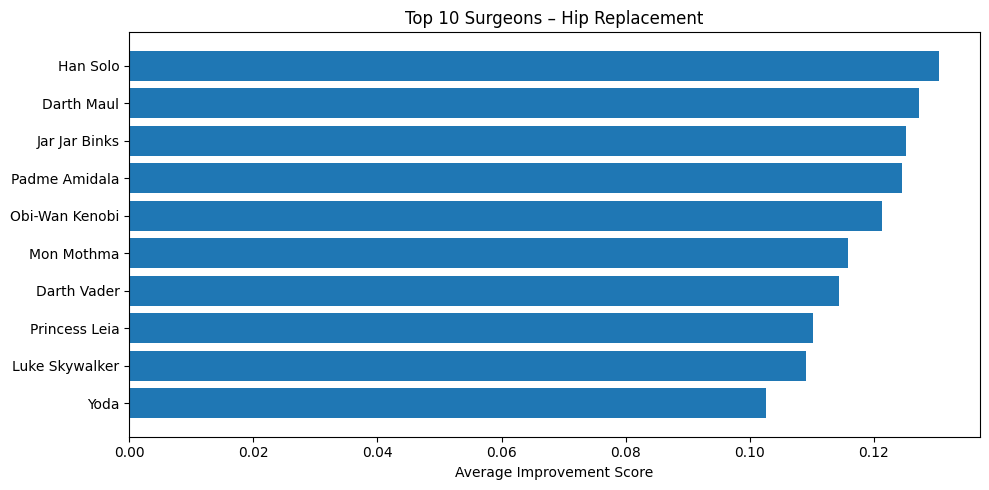

In [15]:
import matplotlib.pyplot as plt

top_10 = surgeon_ranking.head(10)
plt.figure(figsize=(10, 5))
plt.barh(top_10['surgeon_name'], top_10['improvement'])
plt.xlabel("Average Improvement Score")
plt.title("Top 10 Surgeons – Hip Replacement")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

### Output files

- Final surgeon ranking as CSV.
- Notebook as HTML.

In [16]:
surgeon_ranking.to_csv("../output/surgeon_ranking.csv", index=False)